In [4]:
import os.path as osp
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
import utils.hops_sampler as hops_sampler
import utils.cancer_data as pathway
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [10]:
# Load both data and operate by class pathway
pathwayPATH = './Gene_DATA/sourcePathway.txt'
cancerPATH = './BreastCancer/Data_RNASeq2.mat'

# load the overall pathway and cancer data in object
data = pathway.cancer_data(pthwayPATH=pathwayPATH, cancerPATH=cancerPATH)

# sample the protein for the regression problem 
hops_samples_obj = hops_sampler.hops_sampler(pathway = data, 
                                batch_size = 2, # must>1 
                                num_hops = 3,
                                label_all=True)

hops_sample_loader = hops_samples_obj.hops_samples

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_nodes = hops_samples_obj.data.pthway_NameList.shape[0]
model = Node2Vec(num_nodes, embedding_dim=1, walk_length=20,
                 context_size=10, walks_per_node=10)
model= model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
hops_sample_loader[0].edge_index_oriIndexxed

array([[12756, 10679,  3433, ..., 10432, 10172, 10172],
       [12343, 10681,  3506, ..., 11759,  9629, 10184]])

In [28]:
def train():
    model.train()
    total_loss = 0
    for subset in hops_sample_loader:
        optimizer.zero_grad()
        batch = torch.from_numpy(subset.batch).long().to(device)
        edge_index = torch.from_numpy(subset.edge_index_oriIndexxed).long().to(device)
        loss = model.loss(edge_index, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(hops_sample_loader)

In [29]:

for epoch in range(1, 500):
    loss = train()
    print('Epoch: {:02d}, Loss: {:.4f}'.format(epoch, loss))

Epoch: 01, Loss: 1.4714
Epoch: 02, Loss: 1.3518
Epoch: 03, Loss: 1.0188
Epoch: 04, Loss: 0.7405
Epoch: 05, Loss: 0.6186
Epoch: 06, Loss: 0.5541
Epoch: 07, Loss: 0.5148
Epoch: 08, Loss: 0.4884
Epoch: 09, Loss: 0.4703
Epoch: 10, Loss: 0.4566
Epoch: 11, Loss: 0.4467
Epoch: 12, Loss: 0.4385
Epoch: 13, Loss: 0.4320
Epoch: 14, Loss: 0.4275
Epoch: 15, Loss: 0.4242
Epoch: 16, Loss: 0.4208
Epoch: 17, Loss: 0.4181
Epoch: 18, Loss: 0.4164
Epoch: 19, Loss: 0.4145
Epoch: 20, Loss: 0.4129
Epoch: 21, Loss: 0.4118
Epoch: 22, Loss: 0.4111
Epoch: 23, Loss: 0.4098
Epoch: 24, Loss: 0.4095
Epoch: 25, Loss: 0.4086
Epoch: 26, Loss: 0.4085
Epoch: 27, Loss: 0.4080
Epoch: 28, Loss: 0.4074
Epoch: 29, Loss: 0.4075
Epoch: 30, Loss: 0.4073
Epoch: 31, Loss: 0.4070
Epoch: 32, Loss: 0.4067
Epoch: 33, Loss: 0.4066
Epoch: 34, Loss: 0.4063
Epoch: 35, Loss: 0.4064
Epoch: 36, Loss: 0.4064
Epoch: 37, Loss: 0.4062
Epoch: 38, Loss: 0.4062
Epoch: 39, Loss: 0.4063
Epoch: 40, Loss: 0.4062
Epoch: 41, Loss: 0.4061
Epoch: 42, Loss:

KeyboardInterrupt: 

In [30]:
model.eval()
with torch.no_grad():
    z = model(torch.arange(num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.node_class

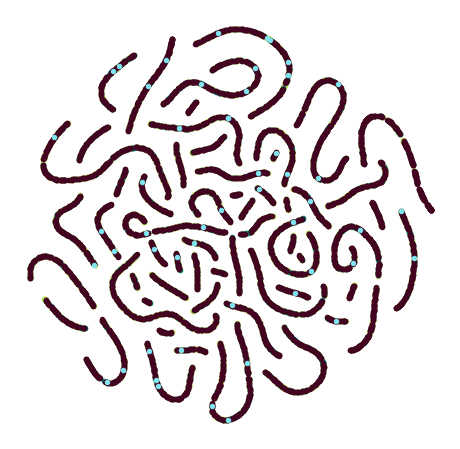

In [31]:
#def plot_points(colors):
#     model.eval()
#     with torch.no_grad():
#         z = model(torch.arange(num_nodes, device=device))
#         z = TSNE(n_components=3).fit_transform(z.cpu().numpy())
#         y = data.node_class
 
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
#ax = Axes3D(plt.figure())
plt.figure(figsize=(8, 8))
for i in range(7):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
plt.axis('off')
plt.savefig('./results/node2vec-embedding/March-25th/node2vec_embed.pdf')
plt.show()

#plot_points(colors)

In [32]:
torch.save(model.state_dict(), './model-dict/node2vec-predembedding/node2vec_1dim.pth')